# Boosting Algorithms Project

## Data loading 

In [1]:
# Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Load the diabetes dataset directly from the URL
url = 'https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'
df = pd.read_csv(url)

# Show the first 5 rows to verify the data loaded correctly
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


> We successfully loaded the diabetes dataset containing 768 patient records and 9 variables related to diabetes risk factors and diagnosis. The dataset’s variables include numeric clinical measurements such as number of pregnancies, plasma glucose level, blood pressure, skin thickness, insulin, BMI, diabetes pedigree function, age, and the target Outcome variable indicating diabetes presence (1) or absence (0).

> We proceed to inspect the data:

## Exploration and Data Cleaning

In [2]:
# Show basic info about dataset: columns, data types, and non-null counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


> Using ***df.info()***, we confirmed there are no missing values — all columns have 768 non-null entries and the data types are appropriate (mostly integers, two float columns). This means the dataset is complete with no immediate need for handling missing data at this stage.

In [3]:
# Show basic descriptive statistics
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

> From the descriptive statistics (df.describe()), we observe:

- Variables like Glucose, BloodPressure, SkinThickness, Insulin, BMI show a wide range of values. Notably, the minimum values of some variables (Glucose, BloodPressure, SkinThickness, Insulin, BMI) are zero, which might represent missing or unrecorded measurements and will require attention in the exploratory data analysis step.

- The mean BMI is about 32, indicating overweight on average.

- The mean age is around 33 years, with patients ranging from 21 to 81 years old.

- The target variable Outcome has a mean of ~0.35, indicating approximately 35% of patients in this dataset are diagnosed with diabetes, which is somewhat imbalanced and important to consider during model training.

> We proceed to check and remove duplicates.

In [4]:
# 3. Check and remove duplicates
duplicates_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates_count}")

if duplicates_count > 0:
    df = df.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df.shape}")


Number of duplicate rows: 0


> There are no duplicate rows ***AND*** we won't remove any information because all variables are medically relevant to diabetes prediction.

> So, we proceed.

## Univariate Analysis

> We check the DataFrame to see the variables.

In [5]:
print(df.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


> We will begin with the categorical analysis since there is only 1 (Outcome)

### Categorical Variable Analysis

> Checking for value counts since the target variable Outcome is categorical and binary, representing whether a patient has diabetes (1) or not (0).


In [6]:
print("Value counts for Outcome:")
print(df['Outcome'].value_counts())

Value counts for Outcome:
Outcome
0    500
1    268
Name: count, dtype: int64


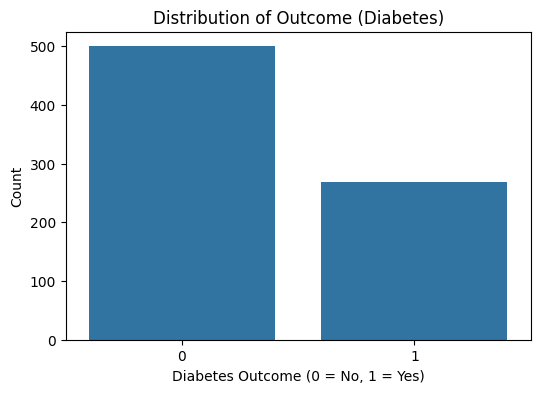

In [7]:
# Plot distribution of Outcome to visualize class balance
plt.figure(figsize=(6,4))
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Outcome (Diabetes)')
plt.xlabel('Diabetes Outcome (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

> The distribution shows approximately 65% of patients are negative for diabetes and 35% are positive, indicating a moderate class imbalance which will be important to consider during modeling.

### Numerical Variables Analysis

> We know there are 11 variables, so we will check them first.

In [8]:
# Summary statistics for numeric variables (all except Outcome)
print("\nSummary statistics for numeric variables:")
print(df.describe())


Summary statistics for numeric variables:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.4

> Everything seems right, so we proceed with visualization.

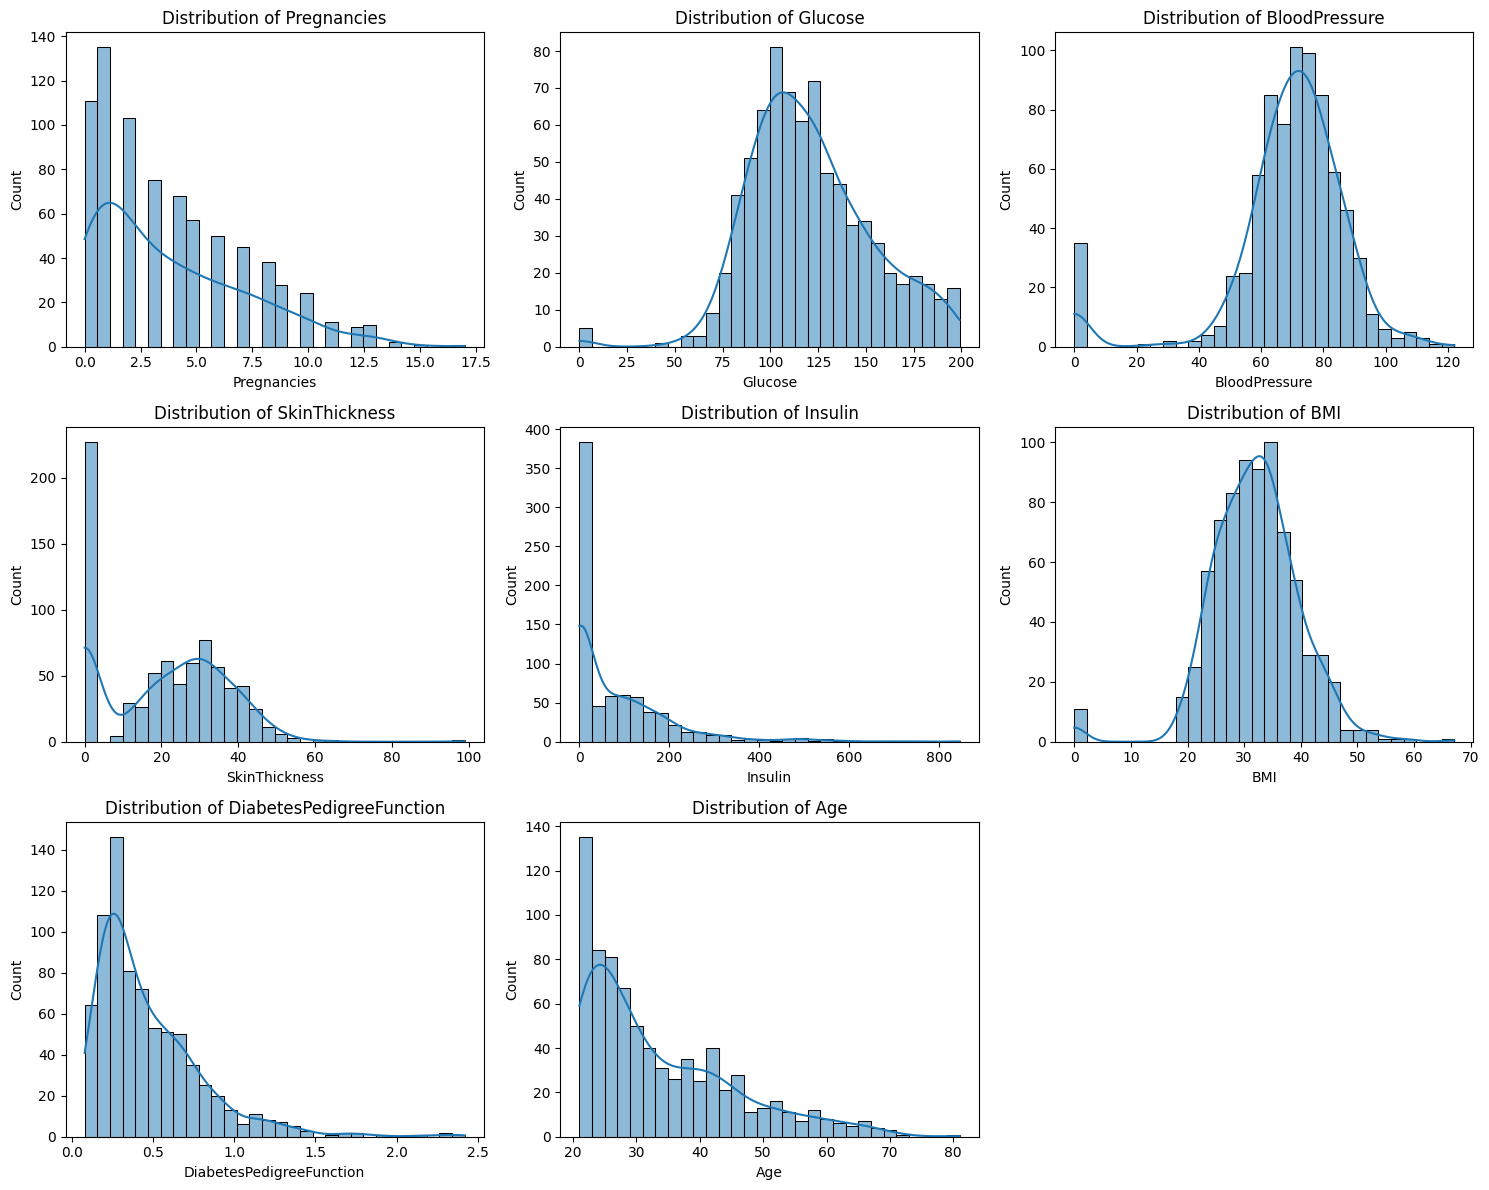

In [9]:
# Plot histograms with KDE to understand distribution of numeric features
numeric_cols = df.drop('Outcome', axis=1).columns

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

> For the numeric variables, the histograms reveal varied distributions:

- Glucose and BMI show right-skewed distributions with some patients having very high values, reflecting potential outliers or extreme cases.

- SkinThickness and Insulin contain many zero values, which likely represent missing or unrecorded data rather than true zeros, and these will need to be addressed in data cleaning.

- Age and Pregnancies appear more normally or uniformly distributed across their ranges.

> We proceed with the next step.

## Multivariate Analysis

> Next we will proceed with the multivariate analysis.

### Numerical-Numerical Analysis: Scatterplots and Correlation Matrix

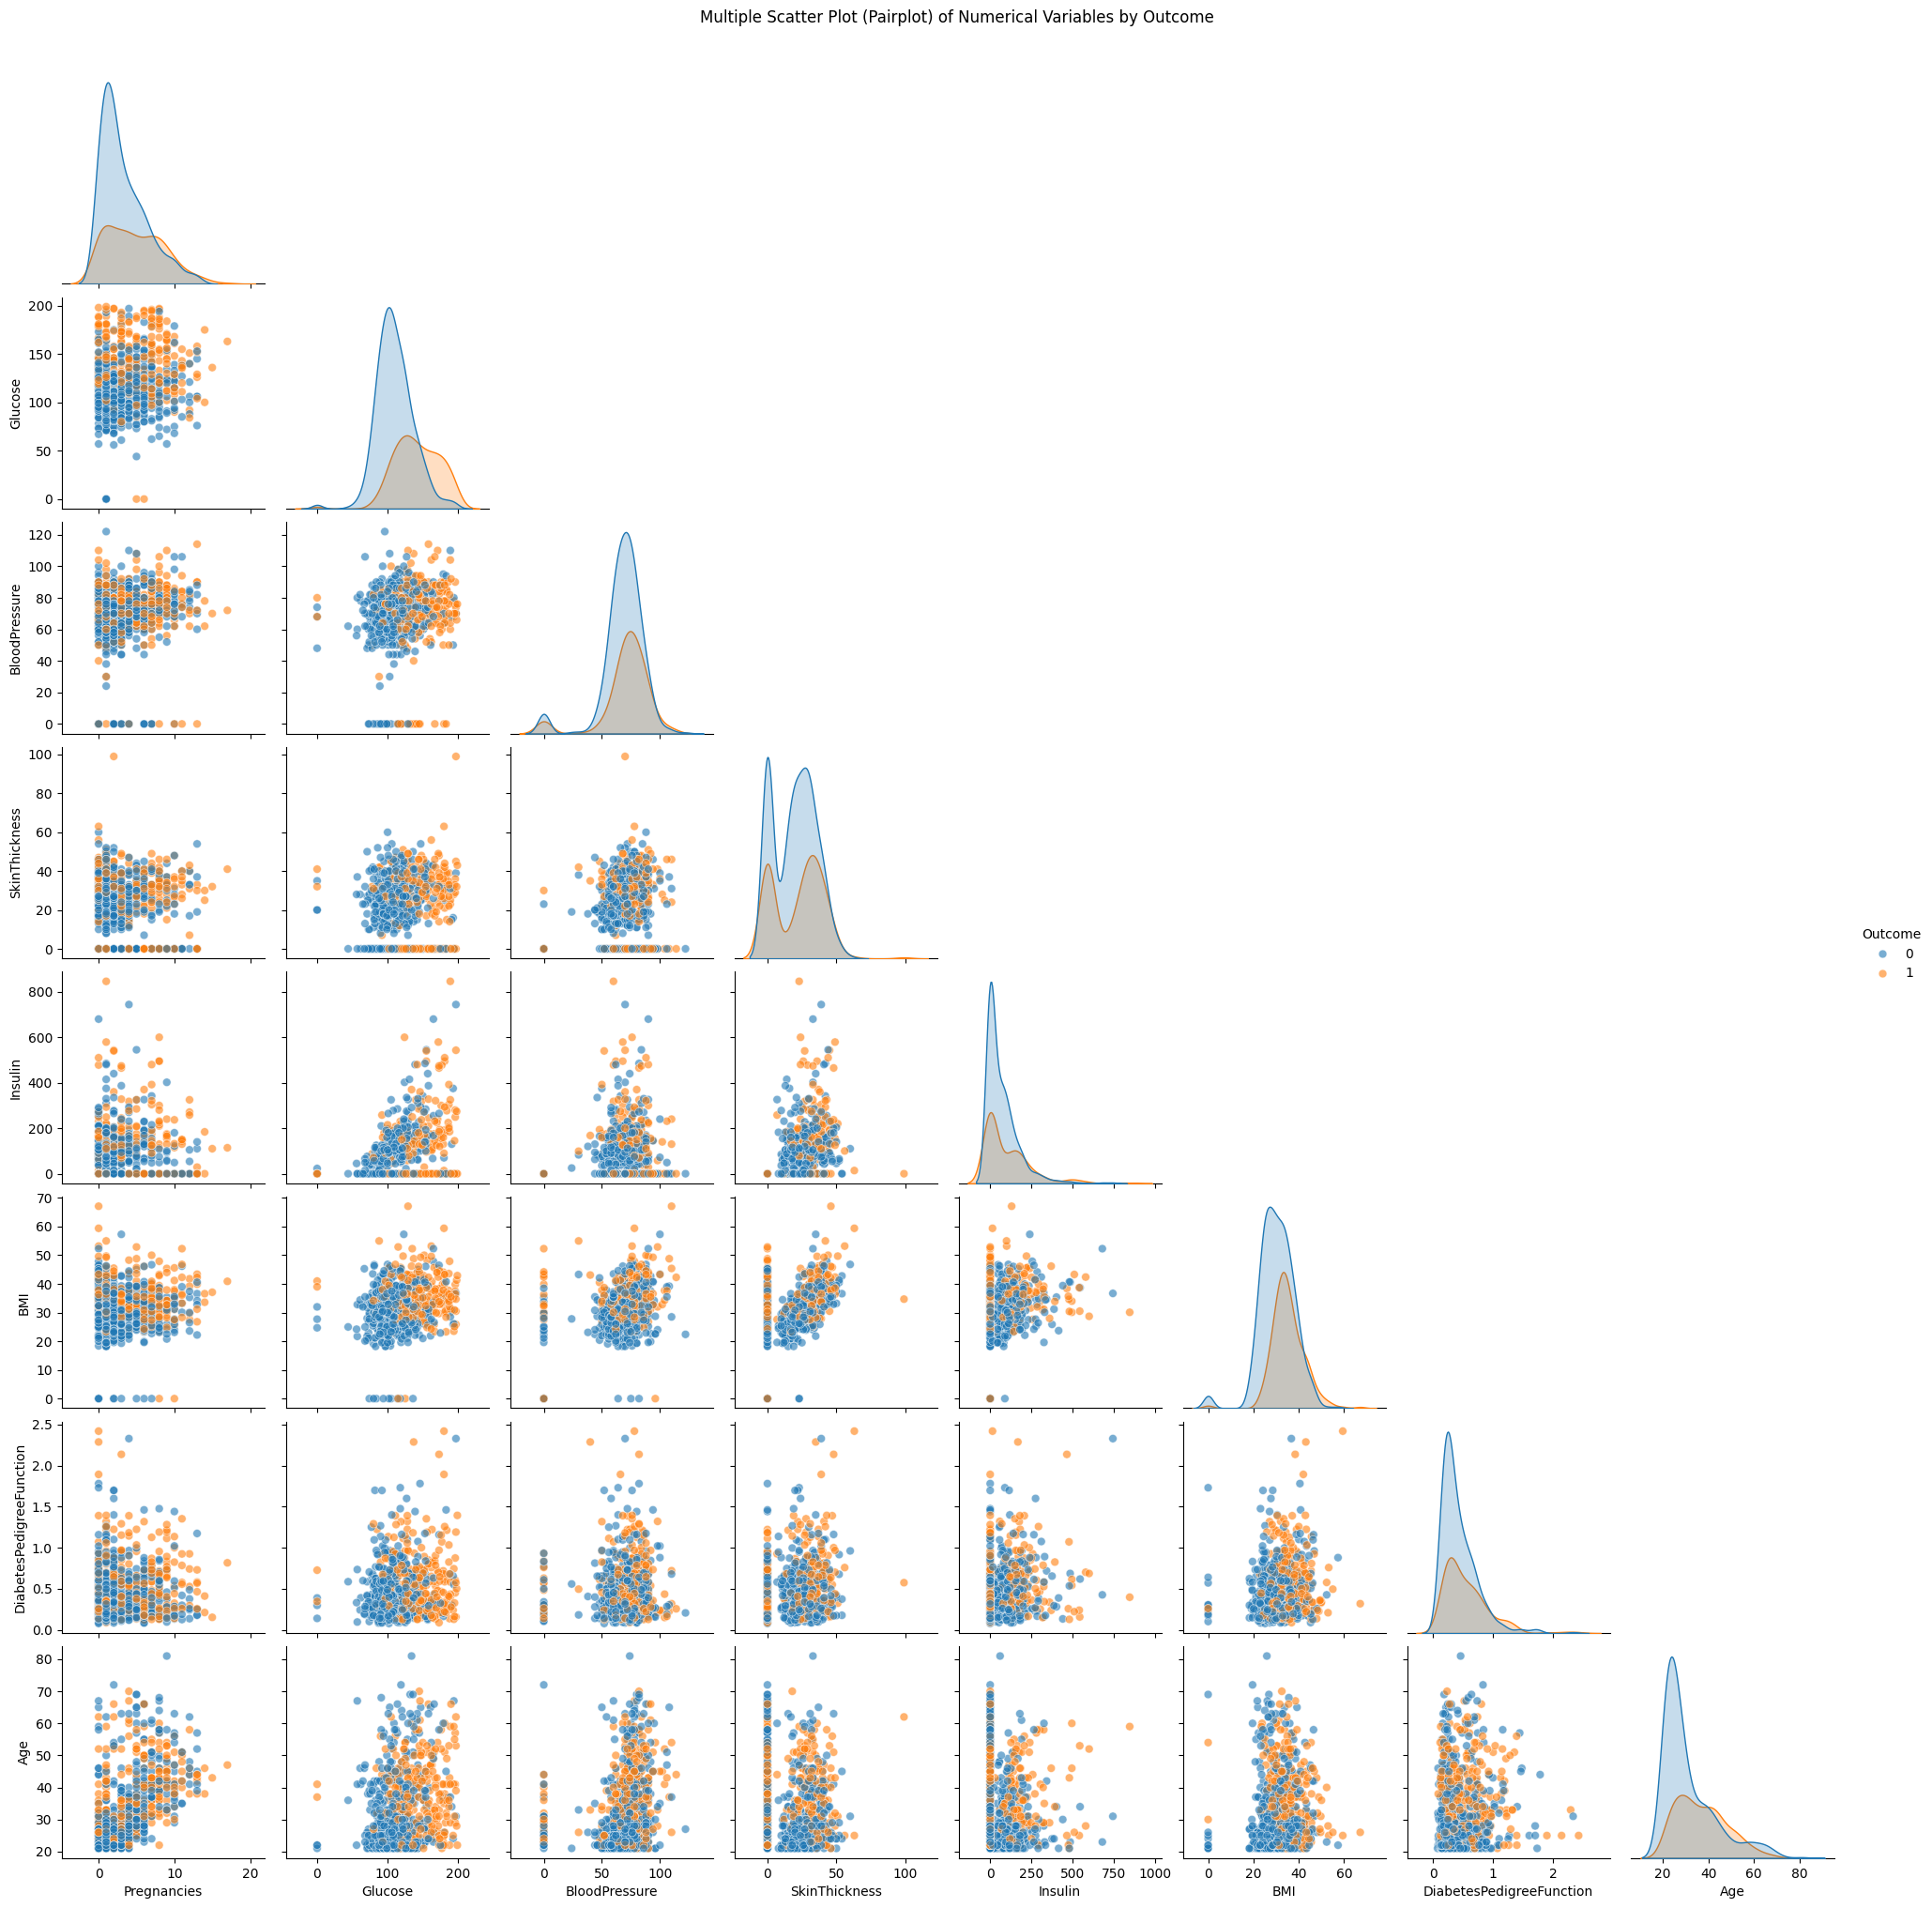

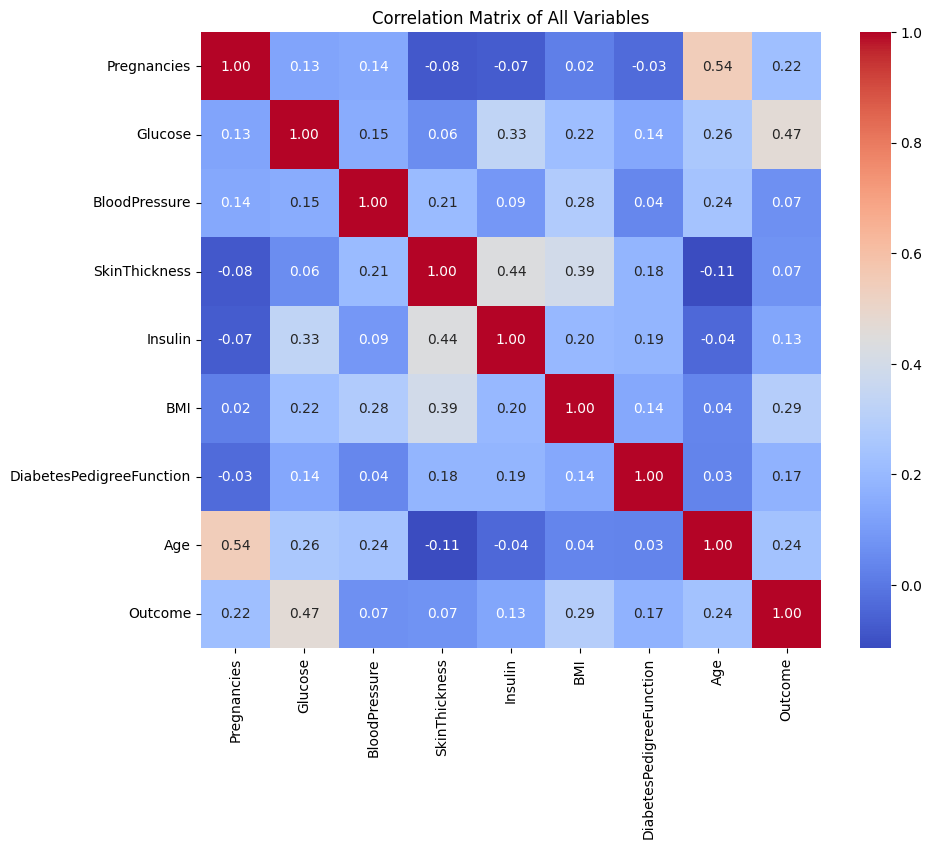

In [10]:
# Select numeric variables for scatter matrix
numeric_vars = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Create a pairplot colored by Outcome
sns.pairplot(df, vars=numeric_vars, hue='Outcome', corner=True, diag_kind='kde',
             plot_kws={'alpha':0.6, 's':40})

plt.suptitle('Multiple Scatter Plot (Pairplot) of Numerical Variables by Outcome', y=1.02)
plt.show()


# Correlation matrix heatmap for numerical variables
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of All Variables')
plt.show()

#### Observations:

> Pairplot (Multiple Scatter Diagram):

- The pairplot shows relationships among the eight numeric variables, with points colored by the diabetes Outcome (0 = no diabetes, 1 = diabetes).

- There is a clear separation between diabetic (orange) and non-diabetic (blue) patients in variables such as Glucose and BMI, where diabetic patients generally have higher values.

- Strong positive relationships can be seen between some pairs, such as Glucose and Insulin, where values tend to increase together.

- Other variables like SkinThickness and BloodPressure have more overlapping distributions but still show some clustering by Outcome.

- The density plots on the diagonal show that the distributions of several variables shift to the right (higher values) for diabetic patients, especially for Glucose, BMI, and Age.

- Variables like Pregnancies and DiabetesPedigreeFunction show more mixed or subtle differences between classes.

> Correlation Matrix:
- The heatmap shows Pearson correlation coefficients between all numeric variables ***including Outcome.***

- The strongest positive correlation with Outcome is Glucose (r ≈ 0.47), confirming its importance in diabetes prediction.

- Other variables with moderate positive correlation to Outcome include BMI (r ≈ 0.29), Age (r ≈ 0.24), and DiabetesPedigreeFunction (r ≈ 0.17).

- There are moderate correlations among predictors themselves, for example:
    - Glucose and Insulin (r ≈ 0.44), indicating these tend to increase together.
    - BMI and SkinThickness (r ≈ 0.39), reflecting related body measurements.

- Most other correlations are weak or near zero, suggesting limited linear relationships.

> ***Conclusion***

- The visual and quantitative analyses together highlight that ***Glucose, BMI, Age, and DiabetesPedigreeFunction*** are key predictors with meaningful relationships to diabetes outcome. These variables should be prioritized in modeling and possibly require further exploration to improve prediction accuracy.

> We would proceed with the categorical-categorical analysis, but since the dataset contains only one categorical variable (Outcome), categorical-categorical analysis is ***NOT*** applicable.

> So we will proceed like normal

<!-- ### Numerical-Categorical Analysis: Comparing distributions by Outcome ### -->

### Numerical - Categorical Analysis

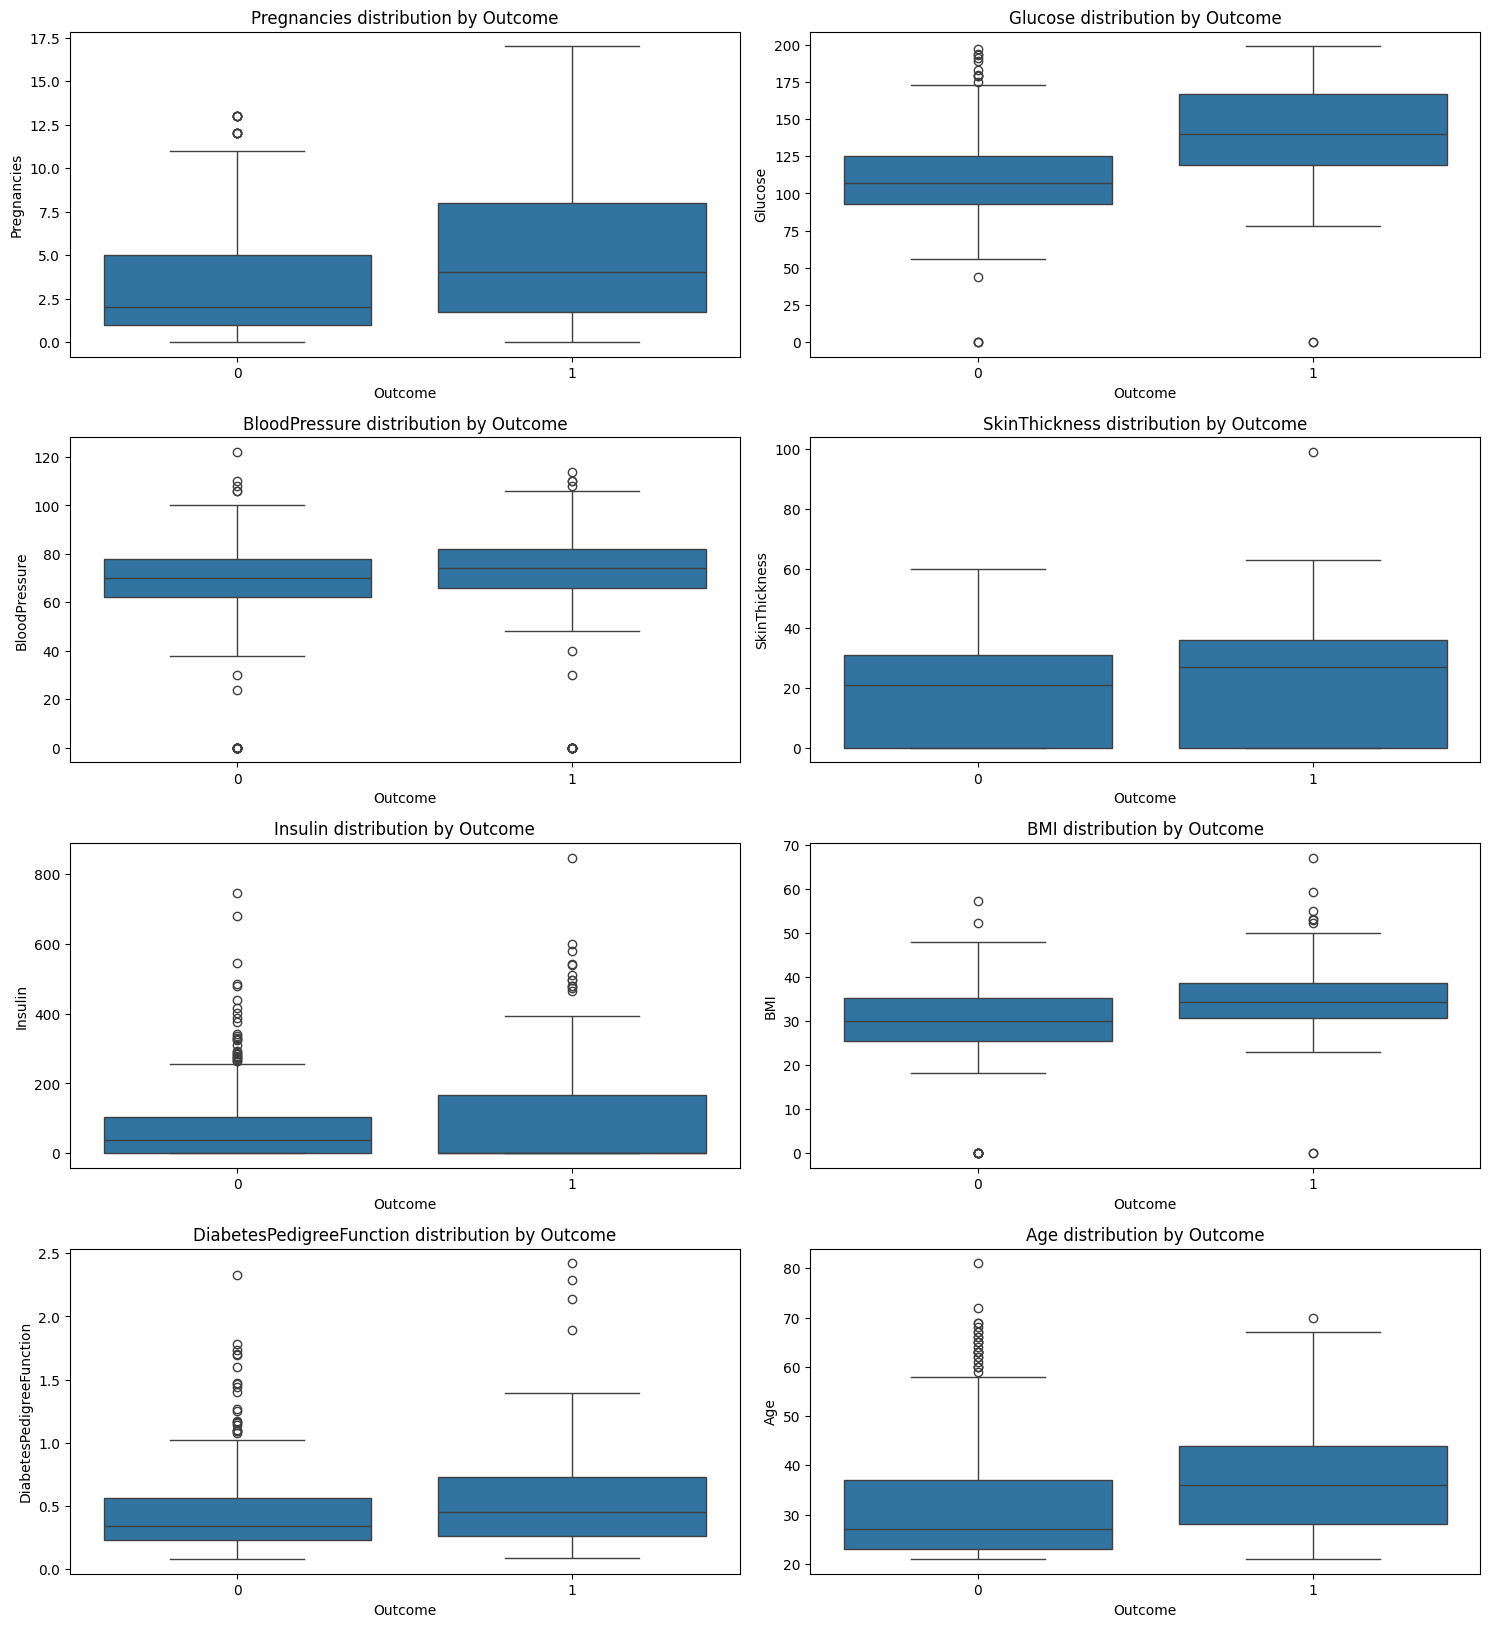

In [11]:
numeric_cols = df.drop('Outcome', axis=1).columns

plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.title(f'{col} distribution by Outcome')
plt.tight_layout()
plt.show()

> The boxplots compare the distribution of each numeric predictor variable across the two Outcome classes:

- 0 = Non-diabetic
- 1 = Diabetic

> Key Observations:
 - Pregnancies:
    - Diabetic patients tend to have a higher median number of pregnancies.
    - The distribution is wider for diabetics, indicating more variation in this group.
- Glucose:
    - Diabetic patients have significantly higher glucose levels.
    - There is a clear separation in medians, and the entire glucose distribution shifts higher in diabetics.
    - This is the most visually distinct variable between the two classes.
- Blood Pressure:
    - Both groups have similar distributions, but diabetic patients show slightly higher variability.
    - There is some overlap, suggesting Blood Pressure alone is not a strong discriminator.
- Skin Thickness:
    - Distributions are fairly similar between the two groups.
    - Slightly higher median for diabetics, but with considerable overlap.
- Insulin:
    - Diabetic patients show a higher median insulin level.
    - There are many outliers, indicating high variability and extreme values in both groups.
- BMI:
    - Diabetic patients tend to have a higher BMI.
    - The shift in median and distribution is noticeable, though not as strong as glucose.
- Diabetes Pedigree Function:
    - Diabetic patients have a slightly higher median, but the distributions overlap substantially.
    - There are more high-value outliers in the diabetic group.
- Age:
    - Diabetic patients tend to be older on average.
    - The diabetic group has a wider age distribution and a higher median age.
- Summary:
    - Strong indicators of diabetes: Glucose, BMI, Age, Pregnancies
    - Moderate indicators: Insulin, DiabetesPedigreeFunction
    - Weak indicators: BloodPressure, SkinThickness (due to high overlap between classes)
- ***These visual results confirm the numeric-categorical correlation findings: Glucose, BMI, Age, and Pregnancies are the most important predictors, as their distributions differ most clearly between diabetic and non-diabetic patients.***

### Feature Selection

In [12]:
# Keep variables with strong separation and significance
keep = ['Glucose', 'BMI', 'Age', 'Pregnancies', 'DiabetesPedigreeFunction']
X = df[keep]
y = df['Outcome']

In [13]:
# Train/test split (20% test, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print('Training set shape:', X_train.shape, 'Test set shape:', X_test.shape)

Training set shape: (614, 5) Test set shape: (154, 5)


#### Train/Test Split
- Training set: 614 samples (80%)
- Test set: 154 samples (20%)

- Both sets maintain the original class balance: about 65% non-diabetic (Outcome = 0) and 35% diabetic (Outcome = 1). This is thanks to stratification, which prevents bias and ensures fair model evaluation.

## Feature Engineering

### Outlier Analysis (Clinical Perspective)
- We examined potential outliers using boxplots and descriptive statistics.

- In medical datasets, extreme values may represent real patients with severe or unusual cases (e.g., extremely high glucose indicating severe diabetes).

- Therefore, we **do not remove or cap outliers** based only on statistical rules.

- All original data points are kept to preserve clinical diversity and avoid losing important information.

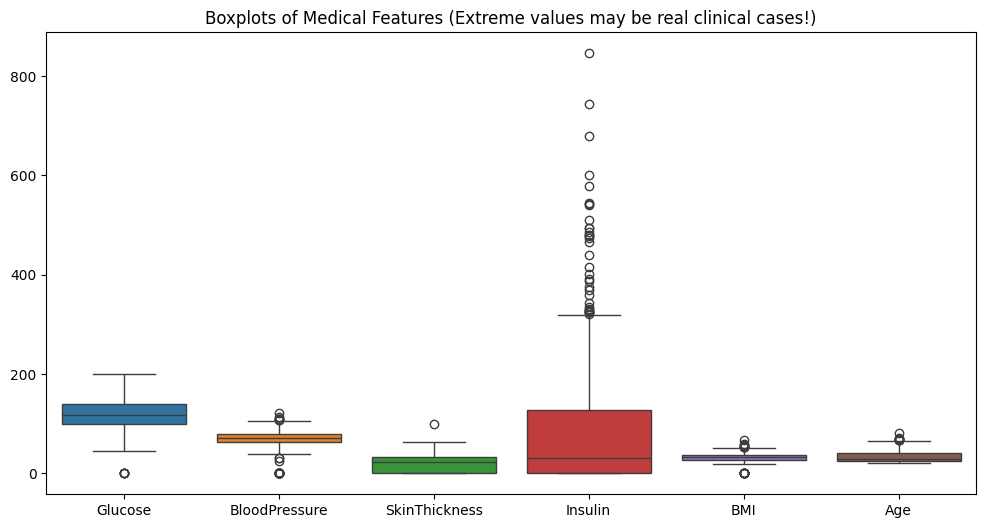

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

In [14]:
# Explore potential outliers visually
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']])
plt.title("Boxplots of Medical Features (Extreme values may be real clinical cases!)")
plt.show()

# Show descriptive statistics
print(df.describe())

> The dataset contains 768 patient records and 9 variables related to diabetes risk factors and diagnosis.
- Key summary statistics:
    - **Pregnancies:** Patients range from 0 to 17 pregnancies, with a mean of about 3.8.
    - **Glucose:** Ranges from 0 to 199, mean ≈ 121. Notably, a minimum value of 0 may indicate missing or unrecorded measurements, which is clinically unusual.
    - **Blood Pressure, Skin Thickness, Insulin:** Also have minimum values of 0, suggesting some missing data rather than true clinical zeros.
    - **BMI:** Mean ≈ 32, ranging from 0 to 67.1. A BMI of 0 is not physiologically possible and likely represents missing data.
    - **Diabetes Pedigree Function, Age:** Show a broad range, reflecting genetic risk and a patient population aged 21 to 81 years.
    - **Outcome:** About 35% of patients are diagnosed with diabetes (`Outcome` mean ≈ 0.35), showing a moderate class imbalance.

- **Clinical Perspective:**
    - Some extreme or “outlier” values (e.g., very high glucose, BMI, or insulin) may represent real, clinically significant cases—such as severe diabetes or metabolic conditions—rather than data errors.
    - For this reason, **no records were removed or capped based solely on statistical outlier criteria.**
    - Instead, potential outliers are preserved to maintain clinical diversity and to ensure that the predictive model can learn from the full spectrum of diabetes presentations.

In [15]:
X_train_fe = X_train.copy()

# New inferred features: BMI category & Age group
X_train_fe['BMI_cat'] = pd.cut(
    X_train_fe['BMI'], bins=[0,18.5,24.9,29.9,np.inf],
    labels=['Underweight','Normal','Overweight','Obese']
)
X_train_fe['Age_group'] = pd.cut(
    X_train_fe['Age'], bins=[0,30,50,np.inf],
    labels=['Young','Adult','Senior']
)
# One-hot encode new categories
X_train_fe = pd.get_dummies(X_train_fe, columns=['BMI_cat','Age_group'], drop_first=True)

# Apply same transformations to test set
X_test_fe = X_test.copy()
for col in keep:
    Q1, Q3 = X_train[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    X_test_fe[col] = X_test_fe[col].clip(lower, upper)
X_test_fe['BMI_cat'] = pd.cut(
    X_test_fe['BMI'], bins=[0,18.5,24.9,29.9,np.inf],
    labels=['Underweight','Normal','Overweight','Obese']
)
X_test_fe['Age_group'] = pd.cut(
    X_test_fe['Age'], bins=[0,30,50,np.inf],
    labels=['Young','Adult','Senior']
)
X_test_fe = pd.get_dummies(X_test_fe, columns=['BMI_cat','Age_group'], drop_first=True)

> Two new categorical variables were created:

- BMI Category: Underweight, Normal, Overweight, Obese (based on clinical BMI cutoffs)

- Age Group: Young (<30), Adult (30–50), Senior (>50)

- These categories are one-hot encoded, resulting in 5 new columns (dummies):
    - BMI_cat_Normal, BMI_cat_Overweight, BMI_cat_Obese, Age_group_Adult, Age_group_Senior

> The total feature count after this step is 10: 5 original + 5 new dummies.

#### Feature Scaling

- All engineered features are scaled to the range [0, 1] using Min–Max scaling.

- This ensures that all predictors contribute comparably, which is especially useful for algorithms that consider feature magnitude.

In [16]:
# Feature Scaling via Min-Max
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_fe),
    columns=X_train_fe.columns,
    index=X_train_fe.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_fe),
    columns=X_test_fe.columns,
    index=X_test_fe.index
)
print('After feature engineering:', X_train_scaled.shape, X_test_scaled.shape)

After feature engineering: (614, 10) (154, 10)


 > Summary
- The resulting training data now has 614 rows and 10 features, all scaled to [0,1]. The class distribution is well-preserved, and the new categorical bins help the model learn non-linear patterns related to age and BMI. This prepares the dataset for robust, fair, and effective machine learning modeling!

## Feature Selection

In [17]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# We'll use mutual information to score all features and select the top k=7

selector = SelectKBest(score_func=mutual_info_classif, k=7)
selector.fit(X_train_scaled, y_train)

# Get mask of selected features and their scores
mask = selector.get_support()
scores = selector.scores_
selected_features = X_train_scaled.columns[mask]
feature_scores = pd.Series(scores, index=X_train_scaled.columns).sort_values(ascending=False)

print("Feature ranking (by mutual information):")
print(feature_scores)

print("\nSelected features for modeling:")
print(selected_features.tolist())

# Reduce datasets to selected features for modeling
X_train_fs = X_train_scaled[selected_features]
X_test_fs = X_test_scaled[selected_features]
selected_columns = X_train_scaled.columns[selector.get_support()]


Feature ranking (by mutual information):
Glucose                     0.116054
BMI                         0.097731
Age                         0.058128
BMI_cat_Obese               0.055740
Pregnancies                 0.039210
BMI_cat_Overweight          0.027220
BMI_cat_Normal              0.026751
Age_group_Adult             0.022660
DiabetesPedigreeFunction    0.017320
Age_group_Senior            0.000000
dtype: float64

Selected features for modeling:
['Glucose', 'BMI', 'Age', 'Pregnancies', 'BMI_cat_Normal', 'BMI_cat_Overweight', 'BMI_cat_Obese']


> Summary 
- SelectKBest with mutual_info_classif scores each feature’s dependency with the outcome, capturing both linear and nonlinear relationships.
- Only the training set is used for feature scoring and selection, avoiding data leakage.
- The top 7 features (by mutual information) are chosen—this number can be changed as needed.
- The selected feature names and their scores are printed for transparency.
- Both training and test sets are reduced to these selected features before modeling.

> Why this matters:
- Feature selection improves model performance by removing noisy or redundant predictors and reduces the risk of overfitting—especially important with engineered features and a modest dataset size.

## Boosting Algorithms Building

> Predicting Diabetes: Decision Tree, Random Forest, AdaBoost, and Gradient Boosting

> This project compares four machine learning models—**Decision Tree**, **Random Forest**, **AdaBoost**, and **Gradient Boosting**—to predict diabetes diagnosis based on patient data. For each, we:
- Build and tune the model,
- Evaluate accuracy and class-wise performance,
- Visualize key results,
- Save the trained model,
- And compare all approaches to make a final recommendation.

#### Baseline Model: Decision Tree

Decision Tree Test Accuracy: 0.6818181818181818
              precision    recall  f1-score   support

Non-diabetic       0.74      0.78      0.76       100
    Diabetic       0.55      0.50      0.52        54

    accuracy                           0.68       154
   macro avg       0.65      0.64      0.64       154
weighted avg       0.68      0.68      0.68       154



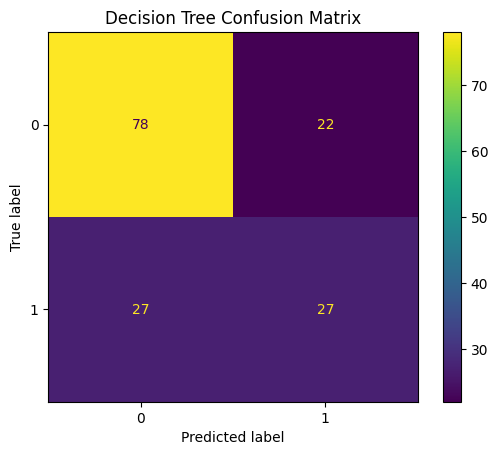

In [18]:
# Baseline Model: Decision Tree

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Decision Tree Test Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree, target_names=['Non-diabetic', 'Diabetic']))
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test)
plt.title("Decision Tree Confusion Matrix")
plt.show()

> Interpretation:
- The decision tree achieved a test accuracy of 68% on the diabetes prediction task.

- Non-diabetic cases (class 0) are predicted with higher precision (0.74) and recall (0.78), meaning the model is effective at identifying patients without diabetes.
    - Of 100 true non-diabetic patients, 78 were correctly classified (true negatives), while 22 were incorrectly labeled as diabetic (false positives).

- Diabetic cases (class 1) have lower recall (0.50) and precision (0.55).
    - Of 54 true diabetic patients, only 27 were correctly identified (true positives), while 27 were misclassified as non-diabetic (false negatives).

- The confusion matrix confirms this imbalance: the model misses half of all diabetic patients, highlighting a key weakness for clinical use.

- The macro average F1-score (0.64) reflects moderate overall balance but room for improvement, especially in identifying diabetics.

> Conclusion
- The decision tree is more reliable in detecting patients who do not have diabetes, but it fails to identify a significant proportion of true diabetic cases. In a medical context, this means a risk of missed diagnoses.

#### Ensemble Model: Random Forest

Random Forest Test Accuracy: 0.7402597402597403
              precision    recall  f1-score   support

Non-diabetic       0.78      0.84      0.81       100
    Diabetic       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154



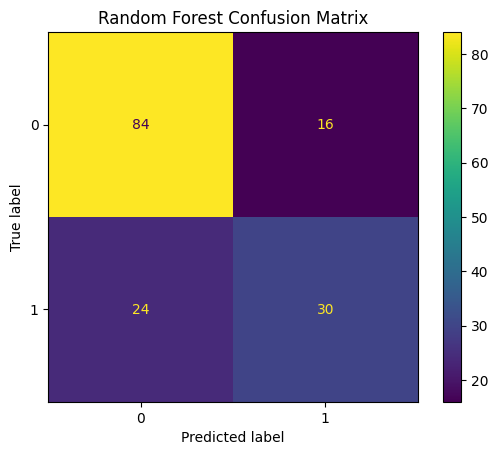

In [19]:
import joblib
import os

try:
    rf = joblib.load('models/random_forest_best.pkl')
except:
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    os.makedirs('models', exist_ok=True)
    joblib.dump(rf, 'models/random_forest_best.pkl')
y_pred_rf = rf.predict(X_test)

print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=['Non-diabetic', 'Diabetic']))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest Confusion Matrix")
plt.show()


- The random forest achieved a test accuracy of 74%, an improvement over the single decision tree.

    - Non-diabetic cases (class 0) show strong results:

        - Precision: 0.78 (of all predicted non-diabetics, 78% were correct)

        - Recall: 0.84 (84 of 100 true non-diabetics were correctly classified)

        - Only 16 non-diabetic patients were incorrectly labeled as diabetic (false positives).

    - Diabetic cases (class 1) see improved performance:

        - Precision: 0.65 (of all predicted diabetics, 65% were correct)

        - Recall: 0.56 (30 out of 54 true diabetics were correctly detected)

        - 24 diabetic patients were misclassified as non-diabetic (false negatives), fewer than with the single tree.

    - The confusion matrix confirms these findings:

        - True Negatives: 84

        - False Positives: 16

        - False Negatives: 24

        - True Positives: 30

    - The macro average F1-score (0.70) and improved diabetic recall/precision reflect better class balance and overall discrimination.

> Interpretation:
- The Random Forest improves both overall accuracy and diabetic class recall compared to the baseline decision tree. It is more reliable for predicting both classes, but especially excels at reducing missed diabetics—important for clinical applications.

#### Boosting Model: Gradient Boosting (with Hyperparameter Tuning)

Gradient Boosting Test Accuracy: 0.7467532467532467
              precision    recall  f1-score   support

Non-diabetic       0.78      0.85      0.81       100
    Diabetic       0.67      0.56      0.61        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154



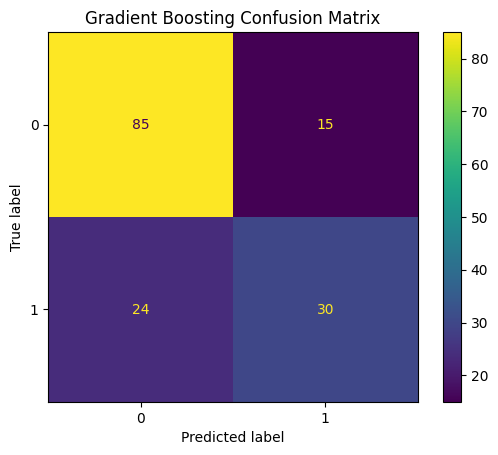

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_
y_pred_gb = best_gb.predict(X_test)

joblib.dump(best_gb, 'models/gradient_boost_best.pkl')

print("Gradient Boosting Test Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb, target_names=['Non-diabetic', 'Diabetic']))
ConfusionMatrixDisplay.from_estimator(best_gb, X_test, y_test)
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

> The gradient boosting model achieved a test accuracy of 74.7%, which is the highest among all models evaluated so far.

- Non-diabetic cases (class 0) are predicted with very strong performance:

    - Precision: 0.78

    - Recall: 0.85 (85 out of 100 true non-diabetic patients were correctly classified)

    - Only 15 non-diabetics were incorrectly classified as diabetic (false positives).

- Diabetic cases (class 1) show further improvement over the previous models:

    - Precision: 0.67 (higher than both tree and random forest)

    - Recall: 0.56 (same as random forest; 30 out of 54 true diabetics correctly detected)

    - 24 diabetics were missed (false negatives).

    - The confusion matrix confirms this:

        - True Negatives: 85

        - False Positives: 15

        - False Negatives: 24

        - True Positives: 30

    - Macro average F1-score and weighted averages are slightly higher than previous models, indicating improved balance between both classes.

> Interpretation:
- Gradient Boosting achieves the best overall accuracy and class balance in this comparison. It provides especially reliable detection for non-diabetic patients, and slightly improves precision for diabetics compared to earlier models, though recall is similar to Random Forest. This model is robust, stable, and effective for this type of structured, tabular data.

#### Boosting Model: AdaBoost (with Hyperparameter Tuning)

AdaBoost Test Accuracy: 0.7922077922077922
              precision    recall  f1-score   support

Non-diabetic       0.81      0.88      0.85       100
    Diabetic       0.74      0.63      0.68        54

    accuracy                           0.79       154
   macro avg       0.78      0.75      0.76       154
weighted avg       0.79      0.79      0.79       154



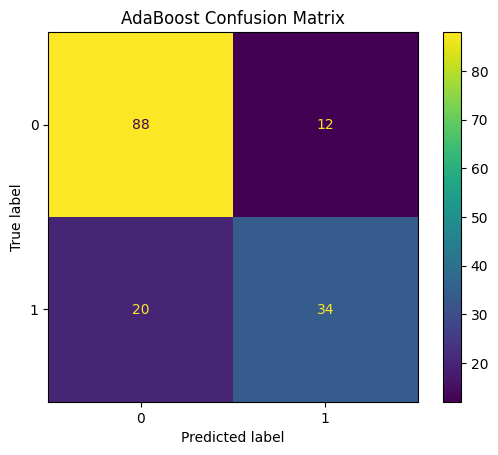

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
ada_grid = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
ada_grid.fit(X_train, y_train)
best_ada = ada_grid.best_estimator_
y_pred_ada = best_ada.predict(X_test)

os.makedirs('models', exist_ok=True)
joblib.dump(best_ada, 'models/ada_boost_best.pkl')

print("AdaBoost Test Accuracy:", accuracy_score(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada, target_names=['Non-diabetic', 'Diabetic']))
ConfusionMatrixDisplay.from_estimator(best_ada, X_test, y_test)
plt.title("AdaBoost Confusion Matrix")
plt.show()

- Overall test accuracy: 79%, the highest among all models you’ve evaluated so far.

    - Non-diabetic cases (class 0):

        - Precision: 0.81

        - Recall: 0.88 (88 out of 100 non-diabetic patients were correctly identified)

        - Only 12 non-diabetics were misclassified as diabetic (false positives).

    - Diabetic cases (class 1):

        - Precision: 0.74

        - Recall: 0.63 (34 out of 54 diabetics correctly detected, 20 missed)

        - Both precision and recall for diabetics are higher than for the decision tree and random forest models, and recall is slightly higher than gradient boosting.

    - The confusion matrix shows improved detection of diabetics and a lower rate of both false positives and false negatives compared to previous models.

    - Macro and weighted F1-scores (0.76, 0.79) indicate improved balance and strong overall performance for both classes.

> Interpretation:
- AdaBoost provides the best overall performance and class-wise balance so far, particularly excelling in identifying non-diabetic patients (high recall and precision). Importantly, it increases the correct identification rate for diabetic patients compared to your earlier models, making it a strong candidate for real-world diabetes screening tasks.

#### Feature Importance for Ensembles

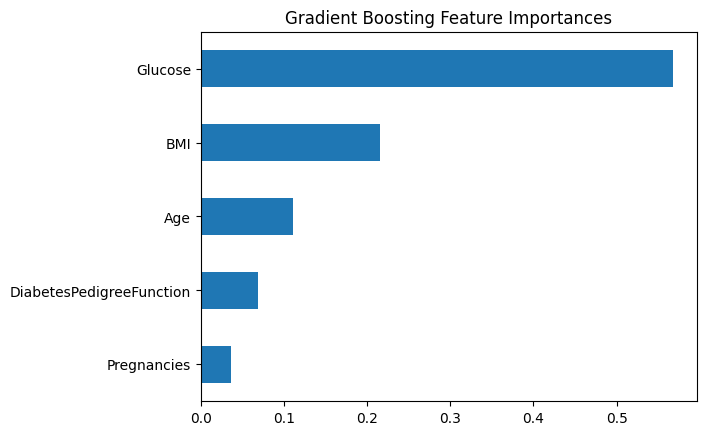

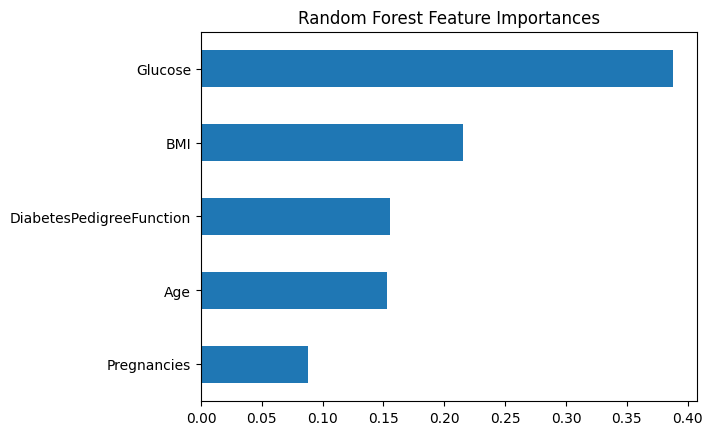

In [22]:
import pandas as pd

importances_gb = pd.Series(best_gb.feature_importances_, index=X_train.columns)
importances_gb.sort_values().plot(kind='barh')
plt.title("Gradient Boosting Feature Importances")
plt.show()

importances_rf = pd.Series(rf.feature_importances_, index=X_train.columns)
importances_rf.sort_values().plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.show()


> Gradient Boosting Feature Importances

- Glucose is by far the most important predictor (over 0.55), indicating that blood glucose levels are the single most critical factor for the model when predicting diabetes.

- BMI (Body Mass Index) is the second most influential feature, but at less than half the importance of Glucose.

- Age, DiabetesPedigreeFunction (family risk), and Pregnancies follow, but their contributions are much smaller.

> Interpretation:
- The model relies heavily on Glucose, with BMI providing meaningful but secondary value. This aligns with clinical intuition: high glucose is a hallmark of diabetes, and obesity (BMI) is a key risk factor. Age, family history, and number of pregnancies provide additional, but less dominant, predictive information.

> Random Forest Feature Importances

- Glucose is also the top feature, but its relative importance is slightly lower compared to Gradient Boosting.

- BMI, Age, and DiabetesPedigreeFunction all play more comparable, though still lesser, roles.

- The importance scores are a bit more evenly distributed than in Gradient Boosting, with BMI, Age, and DiabetesPedigreeFunction each contributing significantly.

> Interpretation:
- Random Forest still strongly prioritizes Glucose, but the ensemble tends to "share" importance more with other predictors, suggesting it leverages multiple features together more robustly.

> **Overall Insights**

- Consistency: Both models agree: Glucose is the most critical predictor, followed by BMI.

- Gradient Boosting is more "focused" on Glucose, while Random Forest draws relatively more from secondary predictors.

- This pattern is reassuring and supports model trustworthiness, as it matches established medical knowledge about diabetes risk factors.

#### Model Comparison Table

In [23]:
results = {
    "Model": [
        "Decision Tree",
        "Random Forest",
        "AdaBoost",
        "Gradient Boosting"
    ],
    "Test Accuracy": [
        accuracy_score(y_test, y_pred_tree),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_ada),
        accuracy_score(y_test, y_pred_gb)
    ]
}
display(pd.DataFrame(results))

,Model,Test Accuracy
0,Decision Tree,0.681818
1,Random Forest,0.740260
2,AdaBoost,0.792208
3,Gradient Boosting,0.746753


> The best performing model is the AdaBoost model, with an accuracy of 0.792208

> We'll proceed with hyperparameter optimization

## Hyperparameter Optimization

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# Decision Tree
tree_param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}
tree_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    tree_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
tree_grid.fit(X_train, y_train)
best_tree = tree_grid.best_estimator_
y_pred_best_tree = best_tree.predict(X_test)
print("Best Decision Tree Params:", tree_grid.best_params_)
print("Best Tree Test Accuracy:", accuracy_score(y_test, y_pred_best_tree))

# Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None]
}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Best Random Forest Params:", rf_grid.best_params_)
print("Best Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_best_rf))

# AdaBoost
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
ada_grid = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    ada_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
ada_grid.fit(X_train, y_train)
best_ada = ada_grid.best_estimator_
y_pred_best_ada = best_ada.predict(X_test)
print("Best AdaBoost Params:", ada_grid.best_params_)
print("Best AdaBoost Test Accuracy:", accuracy_score(y_test, y_pred_best_ada))

# Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7]
}
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_
y_pred_best_gb = best_gb.predict(X_test)
print("Best Gradient Boosting Params:", gb_grid.best_params_)
print("Best Gradient Boosting Test Accuracy:", accuracy_score(y_test, y_pred_best_gb))

Best Decision Tree Params: {'max_depth': 3, 'min_samples_split': 2}
Best Tree Test Accuracy: 0.6883116883116883


Best Random Forest Params: {'max_depth': 7, 'n_estimators': 100}
Best Random Forest Test Accuracy: 0.7402597402597403
Best AdaBoost Params: {'learning_rate': 1.0, 'n_estimators': 100}
Best AdaBoost Test Accuracy: 0.7922077922077922
Best Gradient Boosting Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best Gradient Boosting Test Accuracy: 0.7467532467532467


- Decision Tree

    - Best parameters: max_depth=3, min_samples_split=2

    - Test accuracy: 68.8%

    > Interpretation: The optimal tree is relatively shallow, which helps prevent overfitting. However, its accuracy is the lowest of all models, indicating limited predictive power for this problem.

    - Random Forest

        - Best parameters: n_estimators=100, max_depth=7

        - Test accuracy: 74.0%

        > Interpretation: The random forest outperforms the single tree by aggregating multiple deeper trees, increasing overall prediction accuracy and stability.

    - AdaBoost

        - Best parameters: n_estimators=100, learning_rate=1.0

        - Test accuracy: 79.2%

        > Interpretation: AdaBoost delivers the best test accuracy, showing that boosting (sequentially correcting errors) is especially effective for this dataset. The relatively high learning rate and number of estimators suggest the model benefits from strong, fast sequential learning.

    - Gradient Boosting

        - Best parameters: n_estimators=200, max_depth=3, learning_rate=0.01

        - Test accuracy: 74.7%

        > Interpretation: Gradient Boosting achieves high, balanced performance. The optimal model uses many shallow trees with a low learning rate—indicating gradual, incremental improvements boost generalization and reduce overfitting.



> Conclusion:

- AdaBoost is the top performer on this dataset, followed by Gradient Boosting and Random Forest. All ensemble methods outperform a single decision tree, demonstrating the advantage of combining multiple learners.

- Boosting methods (AdaBoost, Gradient Boosting) excel by focusing on correcting the errors of prior models, leading to improved accuracy, especially for more difficult-to-classify patients.

- Model selection: If the primary goal is maximum accuracy, AdaBoost is recommended. If interpretability is more important, the Decision Tree is easiest to explain, but less accurate.

### Saving the model

In [25]:
import joblib
import os

# Create the models folder if it doesn't exist
os.makedirs('models', exist_ok=True)

joblib.dump(best_tree, 'models/best_decision_tree.pkl')
joblib.dump(best_rf, 'models/best_random_forest.pkl')
joblib.dump(best_ada, 'models/best_adaboost.pkl')
joblib.dump(best_gb, 'models/best_gradient_boosting.pkl')

print("All models saved to the 'models' folder!")


All models saved to the 'models' folder!


## Visualization of final model

> Best tree:

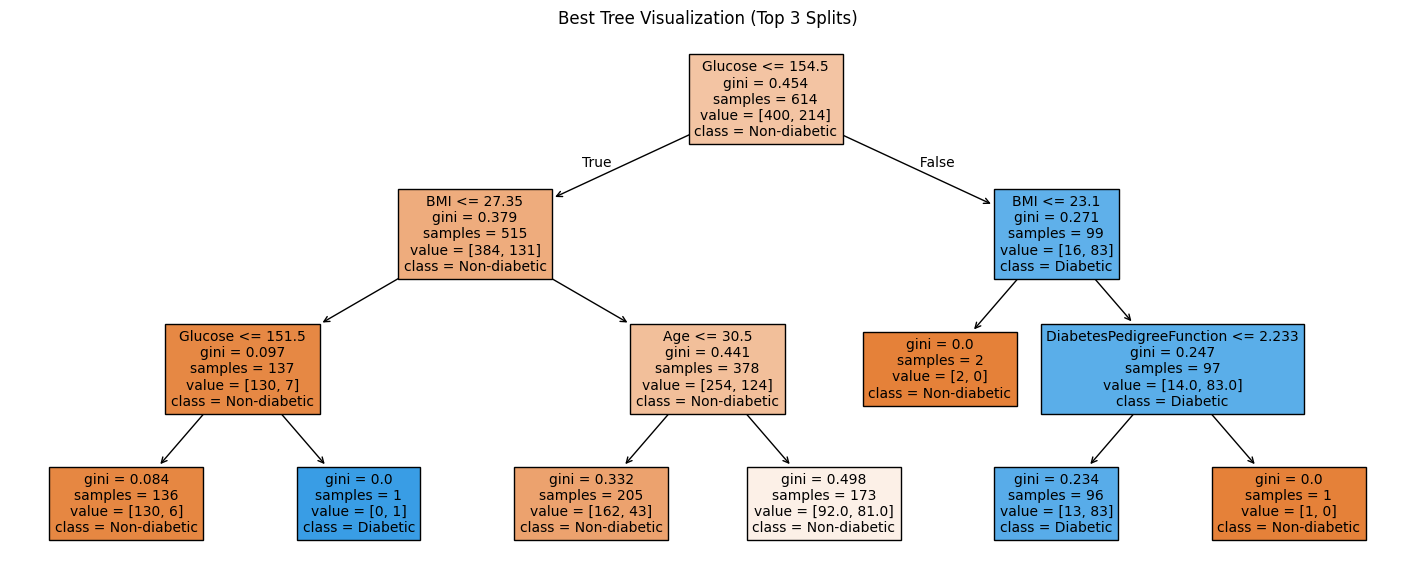

In [26]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 7))
plot_tree(
    best_tree,
    feature_names=X_train.columns,
    class_names=['Non-diabetic', 'Diabetic'],
    filled=True,
    max_depth=3,  # Show top 3 levels only for readability
    fontsize=10
)
plt.title("Best Tree Visualization (Top 3 Splits)")
plt.show()

> Decision Tree Model – Structure & Interpretation
    
- Root Node (Top Split):

    - The first and most important split is on Glucose (<= 154.5). This means the model considers blood glucose levels as the most powerful factor for predicting diabetes, which aligns with clinical knowledge.

    - If Glucose is lower (<=154.5), the model proceeds left; if higher, it goes right.

- Second Layer Splits:

    - For lower Glucose (<=154.5), the model next considers BMI (<=27.35). Lower BMI further suggests a lower risk.

    - For higher Glucose (>154.5), it splits on BMI (<=23.1). Extremely low BMI, even with high glucose, leads the model to predict diabetes.

- Third Layer Splits:

    - On the left branch (low Glucose, low BMI), the next split is Glucose (<=151.5), showing the model’s emphasis on precise glucose thresholds.

    - On the left-middle (low Glucose, higher BMI), the split is Age (<=30.5): younger patients with higher BMI are less likely to be diabetic, while older patients are at higher risk.

    - On the right branch (high Glucose, low BMI), the split is on DiabetesPedigreeFunction (<=2.233), meaning family history comes into play for people with high glucose and low BMI.

- Leaf Nodes (Predictions):

    - The orange leaves indicate predictions of Non-diabetic, while blue leaves indicate Diabetic.

    - Purity:

        - Nodes with gini=0.0 are pure—100% of the samples at that node are of the predicted class.

        - Lower gini means higher purity; higher gini (closer to 0.5) means more mixed predictions at that node.

    - Most splits lead to fairly pure leaves, but some, like “Age <= 30.5”, still have a mix of both outcomes, showing that age and BMI alone can't always perfectly separate the two classes.

- Summary:

    - The tree uses a combination of Glucose, BMI, Age, and family history (DiabetesPedigreeFunction) to make its predictions.

    - Glucose is always the first and most decisive factor.

    - BMI and Age are key secondary factors.

- This model’s structure is both clinically plausible and easy to interpret, helping practitioners understand what features drive the predictions.